# ** Описание **

In [1]:
from __future__ import division

import base64
import csv
import pymorphy2
import gzip
import zlib
import numpy as np
from html.parser import HTMLParser
import re
from bs4 import BeautifulSoup
from urllib.parse import urlparse
import bz2
from gensim.parsing.preprocessing import remove_stopwords, split_alphanum, strip_multiple_whitespaces

from collections import namedtuple

%matplotlib inline
import matplotlib.pyplot as plt
import logging
import importlib

In [2]:
TRACE_NUM = 1000
importlib.reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%H:%M:%S')

def trace(items_num, trace_num=TRACE_NUM):
    if items_num % trace_num == 0: logging.info("Complete items %05d" % items_num)
        
def trace_worker(items_num, worker_id, trace_num=TRACE_NUM):
    if items_num % trace_num == 0: logging.info("Complete items %05d in worker_id %d" % (items_num, worker_id))

### Утилиты

#### Декораторы

In [3]:
def to_utf8(text):
    if isinstance(text, unicode): text = text.encode('utf8')
    return text

def convert2unicode(f):
    def tmp(text):
        if not isinstance(text, unicode): text = text.decode('utf8')
        return f(text)
    return tmp

def convert2lower(f):
    def tmp(text):        
        return f(text.lower())
    return tmp

#P.S. Декораторы могут усложнять отладку, так что от них вполне можно отказаться и воспользоваться copy-paste

### Извлечение текста из html

#### Извлечение текста при помощи встроенных модулей

In [4]:
class TextHTMLParser(HTMLParser):
    def __init__(self):
        HTMLParser.__init__(self)
        self._text = []
        self._title = ""
        self._in_title = False

    def handle_data(self, data):
        text = data.strip()
        if len(text) > 0:
            text = re.sub('[ \t\r\n]+', ' ', text)
            self._text.append(text + ' ')

    def handle_starttag(self, tag, attrs):
        if tag == 'p':
            self._text.append('\n\n')
        elif tag == 'br':
            self._text.append('\n')
        elif tag == 'title':
            self._in_title = True

    def handle_startendtag(self, tag, attrs):
        if tag == 'br':
            self._text.append('\n\n')

    def text(self):
        return ''.join(self._text).strip()
    
def html2title_parser(raw_html):
    title = re.search(r'<title[\w\W]*>[\w\W]*</title>', raw_html)
    if title is not None:
        title = title.group()
        title = title.split('</title>')[0]
        title = re.sub(r'<title[\w\W]*>', '', title)
        return title
    else:
        return ''
    
def html2text_parser(text):
    parser = TextHTMLParser()
    parser.feed(text)
    return parser.text()

#### Извлечение текста при помощи дополнительных библиотек

In [5]:
def html2text_bs(raw_html):
    soup = BeautifulSoup(raw_html, "html.parser")
    [s.extract() for s in soup(['script', 'style'])]
    return soup.get_text()

def html2text_bs_visible(raw_html):
    soup = BeautifulSoup(raw_html, "html.parser")    
    [s.extract() for s in soup(['style', 'script', '[document]', 'head', 'title'])]
    return soup.get_text()

def html2title_bs(raw_html):
    soup = BeautifulSoup(raw_html, "html.parser")
    title = soup.find('title')
    if title:
        return title.get_text()
    else:
        return ''
    
def html_has_h1(raw_html):
    return re.search(r'<h1', raw_html) is not None
    
def html_has_h2(raw_html):
    return re.search(r'<h2', raw_html) is not None
    
def html_has_video(raw_html):
    return re.search(r'<video', raw_html) is not None
    
def html_description_len(raw_html):
    soup = BeautifulSoup(raw_html, "html.parser")
    tag = soup.find("meta", {"name":"description"})
    content = ''
    if tag:
        content += str(tag.get('content'))
        content += str(tag.get('value'))
    return len(content)
    
def html_description_words_num(raw_html):
    soup = BeautifulSoup(raw_html, "html.parser")
    tag = soup.find("meta", {"name":"description"})
    content = ''
    if tag:
        content += str(tag.get('content'))
        content += str(tag.get('value'))
    return len(list(pymorphy_tokenizer(content)))
    
def html_image(raw_html_d):
    tags = re.findall(r'<img', raw_html_d)
    tags_a = raw_html_d.split('</img>')
    count = 0
    for a in tags_a:
        if re.search(r'<img[\w\W]*alt=[\w\W]*>', a):
            count += 1
    return len(tags), count
    
def html_links_anchor(raw_html, self_url):
    out_links = [b'']
    anchors = []
    count = 0
    body = re.search(r'</body>', raw_html)
    tag_a = raw_html.split('</a>')
    for link in tag_a:
        url = re.search(r'<a[\w\W]*href="[\w\W]*"[\w\W]*', link)
        if url:
            url = url.group()
            url = re.search(r'href="[\w\W]*"', url).group()
            url = re.sub(r'href=', '', url)
            out_links.append(urlparse(url).netloc)
            if urlparse(url).netloc == urlparse(self_url).netloc:
                count += 1
    if body:
        for a in tag_a:
            line = re.search(r'<a[\w\W]*>[\w\W]*', a)
            if line:
                anchors.append(re.sub(r'<a[\w\W]*>', '', line.group()))
    return len(tag_a) - 1, len(list(set(out_links))), count, ''.join(anchors)

def html2anchors_bs(raw_html, text=''):
    if text:
        return text
    else:
        soup = BeautifulSoup(raw_html, "html.parser")
        body = soup.find('body')
        anchors = []
        tags_a = soup.find_all('a')
        if body:
            anchors = [a.get_text() for a in tags_a]
        return ''.join(anchors)

#### Выбираем какой метод для конвертации html в текст будет основным

In [6]:
#html2text = html2text_bs
html2text = html2text_parser

#### Методы для токенизации текста

In [7]:
@convert2lower
def easy_tokenizer(text):
    word = ''
    for symbol in text:
        if symbol.isalnum(): word += symbol
        elif word:
            yield word
            word = ''
    if word: yield word

PYMORPHY_CACHE = {}
df = pymorphy2.MorphAnalyzer()

@convert2lower
def pymorphy_tokenizer(text):
    global PYMORPHY_CACHE
    for word in easy_tokenizer(text):
        word_hash = hash(word)
        if word_hash not in PYMORPHY_CACHE:
            PYMORPHY_CACHE[word_hash] = df.parse(word)[0].normal_form            
        yield PYMORPHY_CACHE[word_hash]

#### Основная функция, которая вызывается для преобразования html в список слов

In [8]:
def html2word(raw_html, data='', to_text=html2text, tokenizer=easy_tokenizer):
    if data == '':
        data = to_text(raw_html)
    return tokenizer(data.lower())

#### Рассчет финальных метрик

In [9]:
def safe_divide(a, b):
    if a == 0: return 0.0
    elif b == 0: return 0.0
    else: return a / b

def calculate_metrics(predictions, threshold):    
    """
    Функция подсчета метрик
    Параметры
    predictions - ранки по документам
    threshold  - порог для метрик
    """
    true_positive = 0
    false_positive = 0
    true_negative = 0
    false_negative = 0
    for (url_id, mark, url, prediction) in predictions:        
        mark_predict = prediction > threshold

        if mark_predict:                     
            if mark_predict == mark: true_positive += 1
            else: false_positive += 1                    
        else:                     
            if  mark_predict == mark: true_negative += 1
            else: false_negative += 1

    class_prec  = safe_divide(true_positive, true_positive + false_positive)
    class_recall = safe_divide(true_positive, true_positive + false_negative)
        
    class_F1 = safe_divide(2 * class_prec * class_recall, class_prec + class_recall)
    
    
    not_class_prec = safe_divide(true_negative, true_negative + false_negative)
    not_class_recall = safe_divide(true_negative, true_negative + false_positive)
    
    not_class_F1 = safe_divide(2 * not_class_prec * not_class_recall, not_class_prec + not_class_recall)
    
    return ( (class_prec, class_recall, class_F1), (not_class_prec, not_class_recall, not_class_F1) )

def arange(start, stop, step):
    cur_value = start
    while True:
        if cur_value > stop: break
        yield cur_value
        cur_value += step

def plot_results(docs, min_threshold=-1, max_threshold=1, step=0.1, trace=False):
    x = []
    y_p = []
    y_n = []
    docs_predictions = classifier.predict_all(docs)
    for threshold in arange(min_threshold, max_threshold, step):
        r = calculate_metrics(docs_predictions, threshold)
        x.append(threshold)
        y_p.append(r[0])
        y_n.append(r[1])        
        if trace: 
            print('threshold %s' % threshold)
            print('\tclass_prec %s, class_recall %s, class_F1 %s' % r[0])
            print('\tnot_class_prec %s, not_class_recall %s, not_class_F1 %s' % r[1])
            print('\t\tMacroF1Mesure %s' % ((r[0][2] + r[1][2])/2))
    plot_stats(x, y_p, "Class Result")
    plot_stats(x, y_n, "Not class Result")    


def plot_stats(x, y, title):
    plt.figure(figsize=(10, 5))

    prec, = plt.plot( x, 
                     [k[0] for k in y], "r", label='Precision', 
                     linewidth=1)
    accur, = plt.plot( x, 
                      [k[1] for k in y], "b", label='Recall',
                      linewidth=1)
    f1, =    plt.plot( x, 
                      [k[2] for k in y], "g", label='F1',
                      linewidth=1)
    plt.grid(True)
    plt.legend(handles=[prec, accur, f1])
    plt.title(title)
    plt.show()

In [10]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

def get_stopwords_ratio(words):
    ru_sw = stopwords.words('russian')
    en_sw = stopwords.words('english')
    sw = en_sw + ru_sw
    sw_count = 0
    for word in words:
        if word in sw:
            sw_count += 1
    return safe_divide(sw_count, len(words))
    
def get_text_without_stopwords(words):
    ru_sw = stopwords.words('russian')
    en_sw = stopwords.words('english')
    sw = en_sw + ru_sw
    without_sw = [word for word in words if word not in sw]
    return ' '.join(list(without_sw))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/twinkle/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
stop_words = ['18+', 'секс', 'sex', 'tits',
              'adult en','must be 18', 'must be 21',
              'over 18', 'over 21', 'xxx', 'ass',
             'anal', 'анал', 'bdsm', 'бдсм',
             'киска', 'вирус', 'азиат', 'мулат', 'молодая девушка',
             'adult', 'porn', 'порн', 'инцест',
             'минет', 'куни', 'эроти']

def adult_content(text):
    return len([w for w in stop_words if w in text])

In [12]:
def total_len(words):
    return len(''.join(words))

def get_title_words(html):
    title = html2title_parser(html)
    return len(list(easy_tokenizer(title))), len(title)

def get_anchors_words_num(html, text):
    anchors = html2anchors_bs(html, text)
    anchors_words = easy_tokenizer(anchors)
    return len(list(anchors_words))

class Zlib():
    
    def __init__(self, html):
        self.html = html
        self.compressed = zlib.compress(html)
        
    def get_zlib_compr_num(self):
        return len(self.compressed)

    def get_zlib_compr_lvl(self):
        return safe_divide(len(self.html), len(self.compressed))

class Bz2():
    
    def __init__(self, html):
        self.html = html
        self.compressed = bz2.compress(html)
    
    def get_bz2_compr_num(self):
        return len(self.compressed)

    def get_bz2_compr_lvl(self):
        return safe_divide(len(self.html), len(self.compressed))

class Gzip():
    
    def __init__(self, html):
        self.html = html
        self.compressed = gzip.compress(html)        
    
    def get_gzip_compr_num(self):
        return len(self.compressed)

    def get_gzip_compr_lvl(self):        
        return safe_divide(len(self.html), len(self.compressed))

def is_secure_url(url):
    return re.match('https', url) is not None    
        
def calc_features(url, html_data):
    features = {}
    zlib = Zlib(html_data)
    bz2 = Bz2(html_data)
    gzip = Gzip(html_data)
    html_data_d = ''
    datum = ''
    try:
        html_data_d = html_data.decode('utf-8')
    except:
        html_data_d = html_data.decode('latin-1')
    
    text = remove_stopwords(html_data_d)
    text = split_alphanum(text)
    text =  strip_multiple_whitespaces(text)
    
    datum = html2text(html_data_d)
    
    data = html_links_anchor(html_data_d, url)
    features['links_num'] = data[0]
    features['unique_links_num'] = data[1]
    features['self_links_num'] = data[2]
    features['unique_links_ratio'] = safe_divide(features['unique_links_num'], features['links_num'])

    features['comma_num'] = len(datum.split(','))
    
    words = list(html2word(html_data, data=datum))
    
    features['words_num'] = len(words)
    features['avg_word_len'] = safe_divide(total_len(words), features['words_num'])
    
    #title = get_title_words(html_data_d)
    #features['title_words_num'] = title[0]
    #features['title_len'] = title[1]
    #features['anchor_words_num'] = get_anchors_words_num(html_data, data[3])
    #features['anchor_words_ratio'] = safe_divide(features['anchor_words_num'],
    #                                             features['words_num'])
    
    features['html_len'] = len(html_data)
    
    #features['visible_percent'] = safe_divide(len(html2text_bs_visible(html_data_d)), features['html_len'])
    
    features['zlib_compr_len'] = zlib.get_zlib_compr_num()
    features['zlib_compr_lvl'] = zlib.get_zlib_compr_lvl()
    
    features['bz2_compr_len'] = bz2.get_bz2_compr_num()
    features['bz2_compr_lvl'] = bz2.get_bz2_compr_lvl()
    
    features['gzip_compr_num'] = gzip.get_gzip_compr_num()
    features['gzip_compr_len'] = gzip.get_gzip_compr_lvl()
    
    features['url_ssl_certificate'] = is_secure_url(url)
    features['url_len'] = len(url)
    features['url_subdomains_len'] = len(list(url.split('.')))
    features['url_digits'] = len(re.findall(r'\d', url))
    
    features['h1_presense'] = html_has_h1(html_data_d)
    features['h2_presence'] = html_has_h2(html_data_d)
    features['video_presence'] = html_has_video(html_data_d)
    
    #features['description_len'] = html_description_len(html_data)
    #features['description_words_num'] = html_description_words_num(html_data)
    
    img = html_image(html_data_d)
    features['image_num'] = img[0]
    features['image_with_alt_num'] = img[1]
    
    features['unique_words_num'] = len(list(set(words)))
    features['unique_words_ratio'] = safe_divide(features['unique_words_num'], features['words_num'])
    
    features['stopwords_ratio'] = get_stopwords_ratio(words)   
    features['adult'] = adult_content(datum)
    
    features['text'] = text
    
    #for k, v in features.items():
    #    print(k, v)
    
    return list(features.values())

In [13]:
test_html_data = u'''
<!DOCTYPE html>
<html>
<head>
something
<title>Заголовок 
Ololo</title>
</head>
<body>
<div class="image">GERE<p><a href="images/xxx.jpg">Посмотрите на мою фотографию!</a></p>
    <p><a href="tip.html">Как сделать такое же фото?</a></p> 
<a href="http://www.example.com/eg1">Content1<img  
src="http://image.example.com/img1.jpg" />1</a>
</div>
<img> </img>
<div class="image">
<a href="http://www.example.com/eg2">Content2<img  
src="http://image.example.com/img2.jpg" />&*&"??>?}}{<>{^:~?`}}"@!&&$@**(::LD:ASLFSAW)#(*_)#@</a>
</div>
<div class="image">GERE
<a href="http://www.example.com/eg1">Content1<img  
src="http://image.example.com/img1.jpg" />1</a>
</div>
<img></img>
<div class="image">
<a href="http://www.example.com/eg2">Content2<img  
src="http://image.example.com/img2.jpg" />&*&"??>?}}{<>{^:~?`}}"@!&&$@**(::LD:ASLFSAW)#(*_)#@</a>
</div>
</body>
спам 1 2 3
</html>
'''
test_url = 'http://ololo.sd234f.sfsdfs.sdf'

In [14]:
%%time
test_features = calc_features(test_url, test_html_data.encode())
print(len(test_features), test_features)

28 [6, 2, 0, 0.3333333333333333, 1, 28, 4.857142857142857, 942, 401, 2.349127182044888, 474, 1.9873417721518987, 413, 2.280871670702179, 0, 30, 4, 3, False, False, False, 6, 0, 21, 0.75, 0.10714285714285714, 0, '<!DOCTYPE html> <html> <head> <title>Заголовок Ololo</title> </head> <body> <div class="image">GERE<p><a href="images/xxx.jpg">Посмотрите на мою фотографию!</a></p> <p><a href="tip.html">Как сделать такое же фото?</a></p> <a href="http://www.example.com/eg 1">Content 1<img src="http://image.example.com/img 1.jpg" />1</a> </div> <img> </img> <div class="image"> <a href="http://www.example.com/eg 2">Content 2<img src="http://image.example.com/img 2.jpg" />&*&"??>?}}{<>{^:~?`}}"@!&&$@**(::LD:ASLFSAW)#(*_)#@</a> </div> <div class="image">GERE <a href="http://www.example.com/eg 1">Content 1<img src="http://image.example.com/img 1.jpg" />1</a> </div> <img></img> <div class="image"> <a href="http://www.example.com/eg 2">Content 2<img src="http://image.example.com/img 2.jpg" />&*&"??>?

In [15]:
from multiprocessing import Process, Queue

DocItem = namedtuple('DocItem', ['doc_id', 'is_spam', 'url', 'features'])

WORKER_NUM = 4

def load_csv(input_file_name, calc_features_f):    
    """
    Загружаем данные и извлекаем на лету признаки
    Сам контент не сохраняется, чтобы уменьшить потребление памяти - чтобы
    можно было запускать даже на ноутбуках в классе
    """
    
    with gzip.open(input_file_name) if input_file_name.endswith('gz') else open(input_file_name)  as input_file:            
        headers = input_file.readline()
        
        for i, line in enumerate(input_file):
            trace(i)
            parts = line.decode('utf-8').strip().split('\t')
            url_id = int(parts[0])                                        
            mark = bool(int(parts[1]))                    
            url = parts[2]
            pageInb64 = parts[3]
            html_data = base64.b64decode(pageInb64)
            features = calc_features_f(url, html_data)            
            yield DocItem(url_id, mark, url, features)            
                
        trace(i, 1)  
        
def load_csv_worker(input_file_name, calc_features_f, worker_id, res_queue):    
    with gzip.open(input_file_name) if input_file_name.endswith('gz') else open(input_file_name)  as input_file:            
        headers = input_file.readline()
        for i, line in enumerate(input_file):
            trace_worker(i, worker_id)
            if i % WORKER_NUM != worker_id: continue
            parts = line.decode("utf-8").strip().split('\t')
            url_id = int(parts[0])                                        
            mark = bool(int(parts[1]))                    
            url = parts[2]
            pageInb64 = parts[3]
            html_data = base64.b64decode(pageInb64)
            features = calc_features_f(url, html_data)            
            res_queue.put(DocItem(url_id, mark, url, features))
            
        trace_worker(i, worker_id, 1)  
    res_queue.put(None)
        
def load_csv_multiprocess(input_file_name, calc_features_f):
    processes = []
    res_queue = Queue()    
    for i in range(WORKER_NUM):
        process = Process(target=load_csv_worker, args=(input_file_name, calc_features_f, i, res_queue))
        processes.append(process)
        process.start()
    
    complete_workers = 0
    while complete_workers != WORKER_NUM:
        item = res_queue.get()
        if item is None:
            complete_workers += 1
        else:
            yield item
    for process in processes:
        process.join()

** Обрабатываем входной файл **
<br>
Формат - поля разделенные табуляциями
<br>
0 - идентификатор документа
<br>
1 - метка класса 0 - не спам, 1 - спам
<br>
2 - урл документа
<br>
3 - документ в кодировке base64

Выходной формат - массив кортежей вида
(doc_id, is_spam, url, html_data)

In [16]:
%%time

TRAIN_DATA_FILE  = 'kaggle_train_data_tab.csv.gz'
# TRAIN_DATA_FILE  = 'kaggle/kaggle_train_data_tab_300.csv.gz'

train_docs = list(load_csv_multiprocess(TRAIN_DATA_FILE, calc_features))

03:06:45 INFO:Complete items 00000 in worker_id 0
03:06:45 INFO:Complete items 00000 in worker_id 2
03:06:45 INFO:Complete items 00000 in worker_id 1
03:06:45 INFO:Complete items 00000 in worker_id 3
03:07:10 INFO:Complete items 01000 in worker_id 2
03:07:11 INFO:Complete items 01000 in worker_id 0
03:07:11 INFO:Complete items 01000 in worker_id 3
03:07:15 INFO:Complete items 01000 in worker_id 1
03:07:34 INFO:Complete items 02000 in worker_id 0
03:07:35 INFO:Complete items 02000 in worker_id 3
03:07:36 INFO:Complete items 02000 in worker_id 2
03:07:39 INFO:Complete items 02000 in worker_id 1
03:07:59 INFO:Complete items 03000 in worker_id 0
03:08:02 INFO:Complete items 03000 in worker_id 3
03:08:04 INFO:Complete items 03000 in worker_id 1
03:08:08 INFO:Complete items 03000 in worker_id 2
03:08:26 INFO:Complete items 04000 in worker_id 0
03:08:32 INFO:Complete items 04000 in worker_id 3
03:08:32 INFO:Complete items 04000 in worker_id 1
03:08:33 INFO:Complete items 04000 in worker_id 2


CPU times: user 1.31 s, sys: 348 ms, total: 1.65 s
Wall time: 3min 18s


**FEATURES IN ORDER**
<br>
features['links_num']
<br>
features['unique_links_num']
<br>
features['self_links_num']
<br>
features['unique_links_ratio']
<br>
features['comma_num']
<br>
features['words_num']
<br>
features['avg_word_len']
<br>
features['html_len']
<br>
features['zlib_compr_len']
<br>
features['zlib_compr_lvl']
<br>
features['bz2_compr_len']
<br>
features['bz2_compr_lvl']
<br>
features['gzip_compr_num']
<br>
features['gzip_compr_len']
<br>
features['url_ssl_certificate']
<br>
features['url_len']
<br>
features['url_subdomains_len']
<br>
features['url_digits']
<br>
features['h1_presense']
<br>
features['h2_presence']
<br>
features['video_presence']
<br>
features['image_num']
<br>
features['image_with_alt_num']
<br>
features['unique_words_num']
<br>
features['unique_words_ratio']
<br>
features['stopwords_ratio']
<br>
features['adult']
<br>
features['text']

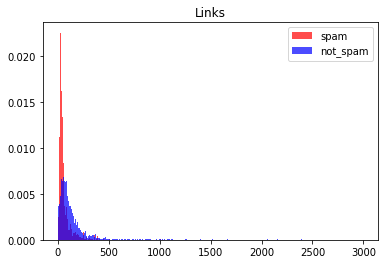

In [17]:
is_spam_data = [doc.features[0] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[0] for doc in train_docs if doc[1] == False]
bins = range(0,3000,10)
plt.hist(is_spam_data, bins=bins, color='red', density=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', density=True, alpha=0.7, label='not_spam')
plt.title('Links')
plt.legend()
plt.show()

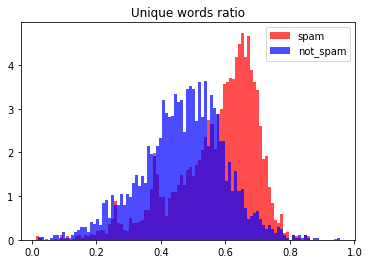

In [18]:
is_spam_data = [doc.features[24] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[24] for doc in train_docs if doc[1] == False]
bins = 100
plt.hist(is_spam_data, bins=bins, color='red', density=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', density=True, alpha=0.7, label='not_spam')
plt.title('Unique words ratio')
plt.legend()
plt.show()

<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


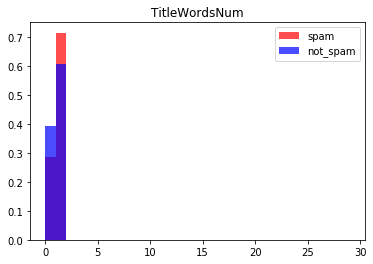

In [19]:
is_spam_data = [doc.features[18] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[18] for doc in train_docs if doc[1] == False]
bins = range(0, 30, 1)
plt.hist(is_spam_data, bins=bins, color='red', density=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', density=True, alpha=0.7, label='not_spam')
plt.title('TitleWordsNum')
plt.legend()
plt.show()

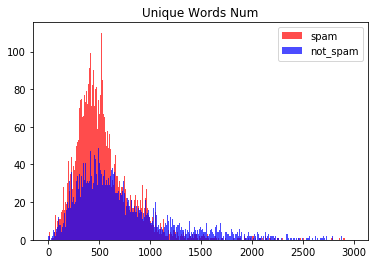

In [20]:
is_spam_data = [doc.features[23] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[23] for doc in train_docs if doc[1] == False]
bins = range(0, 3000, 10)
plt.hist(is_spam_data, bins=bins, color='red', alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', alpha=0.7, label='not_spam')
plt.title('Unique Words Num')
plt.legend()
plt.show()

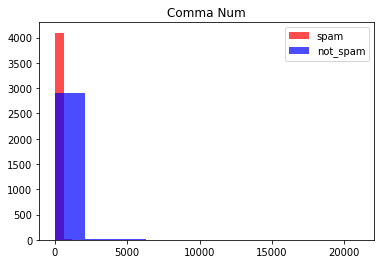

In [21]:
is_spam_data = [doc.features[4] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[4] for doc in train_docs if doc[1] == False]
bins = range(0, 30, 1)
plt.hist(is_spam_data, color='red', alpha=0.7, label='spam')
plt.hist(not_spam_data, color='blue', alpha=0.7, label='not_spam')
plt.title('Comma Num')
plt.legend()
plt.show()

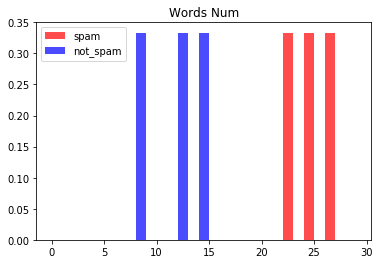

In [22]:
is_spam_data = [doc.features[5] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[5] for doc in train_docs if doc[1] == False]
bins = range(0, 30, 1)
plt.hist(is_spam_data, bins=bins, color='red', density=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', density=True, alpha=0.7, label='not_spam')
plt.title('Words Num')
plt.legend()
plt.show()

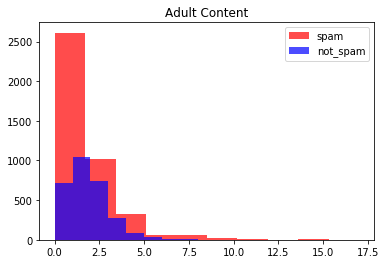

In [23]:
is_spam_data = [doc.features[26] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[26] for doc in train_docs if doc[1] == False]
bins = range(0, 30, 1)
plt.hist(is_spam_data, color='red', alpha=0.7, label='spam')
plt.hist(not_spam_data, color='blue', alpha=0.7, label='not_spam')
plt.title('Adult Content')
plt.legend()
plt.show()

## ** Классификатор: **

Нужно реализовать

In [24]:
import xgboost as xgb
from scipy.stats import uniform, randint
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, make_scorer

class Classifier:
    
    def __init__(self):
        self.params = {
            "colsample_bytree": uniform(0.7, 0.3),
            "gamma": uniform(0, 0.5),
            "learning_rate": uniform(0.03, 0.3),
            "max_depth": randint(2, 10),
            "n_estimators": randint(100, 2000)
        }

        self.clf = xgb.XGBRegressor(objective="binary:hinge",
                                    random_state=42,
                                    subsample=0.5)
        self.scoring = make_scorer(f1_score, average='weighted')
        
        self.tfidf_maxfeatures = 200
        self.vectorizer = TfidfVectorizer(sublinear_tf=True,
                                          use_idf=True,
                                          smooth_idf=True,
                                          max_features=self.tfidf_maxfeatures)
        self.simple_features_len = 0

    def train(self, docs):
        self.fit_vectorizer(docs)
        
        self.simple_features_len = len(docs[0].features) - 1
        
        X = np.zeros((len(docs), self.simple_features_len + self.tfidf_maxfeatures))
        y = np.zeros(len(docs)).astype('int')
         
        for doc_num, doc in enumerate(docs):                            
            X[doc_num, :self.simple_features_len] = doc.features[:-1]
            for i in range(self.tfidf_maxfeatures):
                w = re.findall(self.tfidf_fnames[i], doc.features[-1])
                X[doc_num, self.simple_features_len + i] = len(w)
            y[doc_num] = doc.is_spam
            trace(doc_num)
            
        folds = 5
        param_comb = 5

        skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)
  
        search = RandomizedSearchCV(
            self.clf,
            param_distributions=self.params,
            n_iter=param_comb,
            scoring=self.scoring,
            n_jobs=-1,
            cv=skf.split(X,y),
            verbose=3
        )
        search.fit(X, y)
        print(search.best_params_)
        print(search.best_score_)
        self.best_clf = search.best_estimator_
    
    def predict(self, doc):
        features = np.zeros(self.simple_features_len + self.tfidf_maxfeatures)
        features[:self.simple_features_len] = doc.features[:-1]
        for i in range(self.tfidf_maxfeatures):
            w = re.findall(self.tfidf_fnames[i], doc.features[-1])
            features[self.simple_features_len+i] = len(w)

        ypred = self.best_clf.predict([features])[0]
        return int(ypred)      
    
    def predict_all(self, docs):
        res = []
        for doc_num, doc in enumerate(docs):
            trace(doc_num)
            prediction = self.predict(doc)            
            res.append( (doc.doc_id, doc.is_spam, doc.url, prediction) )
        return res
    
    def fit_vectorizer(self, docs):
        corpus = []
        for doc in docs:
            corpus.append(doc.features[-1])
        
        self.tfidf_train = self.vectorizer.fit_transform(corpus)
        self.tfidf_fnames = self.vectorizer.get_feature_names()
        print(self.tfidf_fnames)

In [25]:
%%time

classifier = Classifier()
classifier.train(train_docs)

03:12:22 INFO:Complete items 00000


['01', '04', '10', '100', '11', '12', '13', '14', '15', '16', '17', '18', '20', '2010', '2011', '21', '22', '24', '25', '30', '31', '50', '80', '82', '_blank', 'action', 'align', 'alt', 'amp', 'b0', 'b5', 'b8', 'background', 'bd', 'be', 'bgcolor', 'block', 'body', 'border', 'bottom', 'br', 'cat', 'category', 'cc', 'cellpadding', 'cellspacing', 'center', 'class', 'co', 'color', 'colspan', 'com', 'comment', 'content', 'counter', 'css', 'd0', 'd1', 'display', 'div', 'document', 'em', 'false', 'ffffff', 'font', 'form', 'forum', 'function', 'gif', 'google', 'head', 'height', 'hidden', 'href', 'htm', 'html', 'http', 'id', 'if', 'image', 'images', 'img', 'index', 'info', 'input', 'item', 'javascript', 'jpg', 'js', 'label', 'language', 'laquo', 'left', 'li', 'link', 'liveinternet', 'livejournal', 'mail', 'margin', 'menu', 'meta', 'middle', 'ms', 'name', 'narod', 'nbsp', 'net', 'new', 'news', 'no', 'nofollow', 'noindex', 'none', 'noscript', 'nowrap', 'onclick', 'option', 'org', 'padding', 'page

03:12:27 INFO:Complete items 01000
03:12:31 INFO:Complete items 02000
03:12:36 INFO:Complete items 03000
03:12:40 INFO:Complete items 04000
03:12:45 INFO:Complete items 05000
03:12:50 INFO:Complete items 06000
03:12:55 INFO:Complete items 07000


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  6.1min finished


{'colsample_bytree': 0.8232802622247639, 'gamma': 0.1598818893750975, 'learning_rate': 0.042300938208821276, 'max_depth': 8, 'n_estimators': 921}
0.9741777146062206
CPU times: user 2min 16s, sys: 416 ms, total: 2min 16s
Wall time: 8min 21s


In [26]:
#Example
classifier.predict(DocItem(0, 0, test_url , test_features))

0

In [27]:
%%time

TEST_DATA_FILE  = 'kaggle_test_data_tab.csv.gz'
# TEST_DATA_FILE  = 'kaggle/kaggle_train_data_tab_300.csv.gz'

test_docs = list(load_csv_multiprocess(TEST_DATA_FILE, calc_features))

03:19:42 INFO:Complete items 00000 in worker_id 0
03:19:42 INFO:Complete items 00000 in worker_id 1
03:19:42 INFO:Complete items 00000 in worker_id 2
03:19:42 INFO:Complete items 00000 in worker_id 3
03:20:11 INFO:Complete items 01000 in worker_id 2
03:20:14 INFO:Complete items 01000 in worker_id 1
03:20:23 INFO:Complete items 01000 in worker_id 3
03:20:30 INFO:Complete items 01000 in worker_id 0
03:20:40 INFO:Complete items 02000 in worker_id 2
03:20:41 INFO:Complete items 02000 in worker_id 1
03:21:03 INFO:Complete items 02000 in worker_id 0
03:21:03 INFO:Complete items 02000 in worker_id 3
03:21:13 INFO:Complete items 03000 in worker_id 2
03:21:14 INFO:Complete items 03000 in worker_id 1
03:21:30 INFO:Complete items 03000 in worker_id 3
03:21:34 INFO:Complete items 03000 in worker_id 0
03:21:41 INFO:Complete items 04000 in worker_id 2
03:21:42 INFO:Complete items 04000 in worker_id 1
03:22:02 INFO:Complete items 04000 in worker_id 0
03:22:02 INFO:Complete items 04000 in worker_id 3


CPU times: user 3.55 s, sys: 731 ms, total: 4.28 s
Wall time: 8min 23s


In [28]:
%%time
print(len(test_docs))
with open('my_submission.csv' , 'wt') as fout:
    writer = csv.writer(fout)
    writer.writerow(['Id','Prediction'])
    for item in classifier.predict_all(test_docs):
        writer.writerow([item[0], item[3]])

03:28:06 INFO:Complete items 00000


16039


03:28:12 INFO:Complete items 01000
03:28:21 INFO:Complete items 02000
03:28:27 INFO:Complete items 03000
03:28:33 INFO:Complete items 04000
03:28:39 INFO:Complete items 05000
03:28:46 INFO:Complete items 06000
03:28:52 INFO:Complete items 07000
03:28:59 INFO:Complete items 08000
03:29:06 INFO:Complete items 09000
03:29:14 INFO:Complete items 10000
03:29:22 INFO:Complete items 11000
03:29:29 INFO:Complete items 12000
03:29:35 INFO:Complete items 13000
03:29:44 INFO:Complete items 14000
03:29:51 INFO:Complete items 15000
03:29:58 INFO:Complete items 16000


CPU times: user 1min 52s, sys: 59.2 ms, total: 1min 52s
Wall time: 1min 52s
